In [916]:
import os
import imageio
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import visvis as vv

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier



In [917]:
letterDict={
  "a": 0,"b": 1,"c": 2,"d": 3,"e": 4,"f": 5,"g": 6,"h": 7,"i": 8,
    "j": 9,"k": 10,"l": 11,"m": 12,"n": 13,"o": 14,"p": 15,"q": 16,"r": 17,
    "s": 18,"t": 19,"u": 20,"v": 21,"w": 22,"x": 23,"y": 24,"z": 25}

numberDict={
    0:"A", 1:"B", 2:"C", 3:"D", 4:"E", 5:"F", 6:"G", 7:"H", 8:"I",
    9:"J", 10:"K", 11:"L", 12:"M", 13:"N", 14:"O", 15:"P", 16:"Q", 17:"R",
    18:"S", 19:"T", 20:"U", 21:"V", 22:"W", 23:"X", 24:"Y", 25:"Z"}


def readPicture(df_complete, directory,letter_value):
    im = imageio.imread(directory)
    im.shape
    print("Letter value: ", directory, end="\r")

    im=np.reshape(im,400)
    df = pd.DataFrame(data=im).T
    y = np.repeat(0,400)
    df['Letter'] = letter_value
    
    return df_complete.append(df, ignore_index=True)

#Method ment for adding augmented pictures to a dataset
def addPictureToDataset(dataset, picture, letter_value):
    picture = np.reshape(picture,400)
    df = pd.DataFrame(data=picture).T
    df['Letter'] = letter_value
    return dataset.append(df, ignore_index=True)



### Loading all images and augmenting. Loading into dataframes

In [1098]:
def read_all_images(upper_directory):
    number_of_images = 0
    original_imgs = pd.DataFrame()
    aug20 = pd.DataFrame()
    aug90 = pd.DataFrame()
    aug270 = pd.DataFrame()
    aug320 = pd.DataFrame()
    for subdir, dirs, files in os.walk(upper_directory):
        for file in files:
            number_of_images+=1
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + file
            if filepath.endswith(".jpg"):
                # print(filepath)
                # Rotate every image that is being loaded:
            
                x = filepath.split("/")
                rotate20 = rotate_image(filepath,x[-1],20)
                rotate90 = rotate_image(filepath,x[-1],90)
                rotate270 = rotate_image(filepath,x[-1],270)
                rotate320 = rotate_image(filepath,x[-1],320)
                
                # zoomed:
                zoomed = zoom_images_and_save(filepath,x[-1])
            
                # The label for the data:
                letter = (x[-1][0])
                letter_val = letterDict.get(letter)
                original_imgs = readPicture(original_imgs,filepath,letter_val)
                aug20 = addPictureToDataset(aug20, rotate20, letter_val)
                aug90 = addPictureToDataset(aug90, rotate90, letter_val)
                aug270 = addPictureToDataset(aug270, rotate270, letter_val)
                aug320 = addPictureToDataset(aug320, rotate320, letter_val)

                # zoomed:
                aug320 = addPictureToDataset(aug320, zoomed, letter_val)
                
    print("image")
    # vv.imshow("./dataset3/chars74k-lite/augmented/rotated_neg_a102.jpg")
    print("number_of_images", number_of_images)
    return original_imgs, aug20, aug90, aug270, aug320


#Rotates an image, stores it in a folder and returns the rotated image
def rotate_image(image_path,ending,deg):
    out_path = "./dataset3/augmented/"
    image_to_rotate = plt.imread(image_path)

    # Rotating the image:
    rotated_positive = ndimage.rotate(image_to_rotate, deg, reshape=False)
   
    fullpath = os.path.join(out_path, 'rotated_'+ str(deg) + '_' + ending)

    imageio.imwrite(fullpath, rotated_positive)
    return rotated_positive
                   
# Unaugmented data, no feature selection:            
original_raw, aug20, aug90, aug270, aug320 = read_all_images("./dataset3/chars74k-lite")

imager value:  ./dataset3/chars74k-lite/z/z_9.jpggg4445.jpgt3/chars74k-lite/a/a_284.jpg./dataset3/chars74k-lite/a/a_360.jpg ./dataset3/chars74k-lite/a/a_445.jpg ./dataset3/chars74k-lite/a/a_507.jpg ./dataset3/chars74k-lite/b/b_87.jpg ./dataset3/chars74k-lite/c/c_144.jpg ./dataset3/chars74k-lite/d/d_96.jpg ./dataset3/chars74k-lite/e/e_349.jpg ./dataset3/chars74k-lite/e/e_469.jpg ./dataset3/chars74k-lite/e/e_492.jpg ./dataset3/chars74k-lite/f/f_62.jpg ./dataset3/chars74k-lite/g/g_106.jpg ./dataset3/chars74k-lite/g/g_172.jpg ./dataset3/chars74k-lite/i/i_142.jpg./dataset3/chars74k-lite/j/j_107.jpg ./dataset3/chars74k-lite/j/j_15.jpg ./dataset3/chars74k-lite/j/j_9.jpg ./dataset3/chars74k-lite/k/k_62.jpg ./dataset3/chars74k-lite/l/l_214.jpg ./dataset3/chars74k-lite/m/m_103.jpg ./dataset3/chars74k-lite/m/m_55.jpg ./dataset3/chars74k-lite/n/n_331.jpg ./dataset3/chars74k-lite/n/n_461.jpg./dataset3/chars74k-lite/n/n_466.jpg ./dataset3/chars74k-lite/n/n_8.jpg./dataset3/chars74k-lite/o/o_302.jpg .

### Data augmentation Zoom (Added to the dataset in read_all_images()):

In [919]:

def cv2_clipped_zoom(img, zoom_factor):
    """
    Center zoom in/out of the given image and returning an enlarged/shrinked view of 
    the image without changing dimensions
    Args:
        img : Image array
        zoom_factor : amount of zoom as a ratio (0 to Inf)
    """
    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)

    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]

    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)

    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result
# print(original_raw[0].tolist())

#"./dataset3/chars74k-lite/a/a_4.jpg"
def zoom_images_and_save(path,ending):
    #img = imageio.imread(path)
    #plt.imshow(img)
    #plt.show()
    
    img = imageio.imread(path)
    zoomed = cv2_clipped_zoom(img, 0.5)
    # plt.imshow(zoomed)

    out_path = "./dataset3/augmented/"
    # zoomed = plt.imread(image_path)

   
    fullpath = os.path.join(out_path, 'zoomed'+'_' + ending)

    imageio.imwrite(fullpath, zoomed)
    return zoomed

In [1135]:
#Methood merges dataset1 with dataset2
def mergeData(dataset1, dataset2):
    return dataset1.append(dataset2, ignore_index=True)

mergedData = mergeData(original_raw, aug20)
mergedData = mergeData(mergedData, aug90)
mergedData = mergeData(mergedData, aug270)
mergedData = mergeData(mergedData, aug320)

In [921]:
# splitting function:
def get_train_test_set(data):
    train_set = pd.DataFrame()
    test_set = pd.DataFrame()
    
    for i in range(26):
        train, test = train_test_split(data.loc[data['Letter']==i], 
                                       test_size=0.2, shuffle=True)
        
        train_set = train_set.append([train], ignore_index=True)
        test_set = test_set.append([test], ignore_index=True)
    return train_set, test_set

## Running models on the data:
### kNN (On Raw, merged, feature-treated data)


In [922]:
#### Running models on the raw data:

def calc_predictions(classifier, train):
    y_pred = []
    n = train.shape[0]
    counter = 0
    clf = classifier.fit(train.drop(labels='Letter', axis = 1), train.iloc[:,-1])
    for row in train.drop(labels='Letter', axis = 1).iterrows():
        y_pred.append(clf.predict([row[1].tolist()]))
        counter +=1
        print((counter/n)*100,"%",end="\r")
    return y_pred,clf

def test_classifier(clf, data):
    y = []
    for row in data.drop(labels='Letter', axis = 1).iterrows():
        y.append(clf.predict(([row[1].tolist()])))
    return y



#### Splitting the raw set and running knn:

In [1101]:

# Raw training and test set:
train_set_raw, test_set_raw = get_train_test_set(original_raw)

#### KNN #####
neigh = KNeighborsClassifier(n_neighbors=3)
y_raw_train_pred, clf = calc_predictions(neigh,train_set_raw)

y_test_pred = test_classifier(clf, test_set_raw)


#### Splitting the merged set and running knn:

In [1100]:
### Running model on the augmented + raw data:

train_set_merged, test_set_merged = get_train_test_set(mergedData)

neigh = KNeighborsClassifier(n_neighbors=3)
y_merged_train_pred, clf_n = calc_predictions(neigh, train_set_merged)

y_merged_test_pred = test_classifier(clf_n, test_set_merged)


### Accuracy scores for knn

In [976]:
## Raw data:
# Train:
print("accuracy_score_knn_training_data:", accuracy_score( train_set_raw.iloc[:,-1],y_raw_train_pred))
# Test:
print("accuracy_score_knn_test_data:", accuracy_score( test_set_raw.iloc[:,-1],y_test_pred))


print(train_set_merged.iloc[:,-1].shape)

## Merged data:
# Train:
print("accuracy_score_knn_training_data:", accuracy_score( train_set_merged.iloc[:,-1],y_merged_train_pred))
# Test
print("accuracy_score_knn_test_data:", accuracy_score( test_set_merged.iloc[:,-1],y_merged_test_pred))



accuracy_score_knn_training_data: 0.8383802816901409
accuracy_score_knn_test_data: 0.6801675977653632
(34128,)
accuracy_score_knn_training_data: 0.8413326300984529
accuracy_score_knn_test_data: 0.6987359550561798


## Random Forest (On Raw, merged, feature-treated data)


In [1256]:
clf_rf = RandomForestClassifier(n_estimators=200,random_state=0)

y_raw_train_pred_rf, clf_rf = calc_predictions(clf_rf,train_set_raw)

y_test_pred_rf = test_classifier(clf_rf, test_set_raw)

In [ ]:
y_merged_train_pred_rf, clf_rf = calc_predictions(clf_rf, train_set_merged)

y_merged_test_pred_rf = test_classifier(clf_rf, test_set_merged)


### Accuracy scores for random forest

In [1255]:
### Random forest accuracy:
## Raw data:
# Train:
print("accuracy_score_randomforest_training_data:", accuracy_score( train_set_raw.iloc[:,-1],y_raw_train_pred_rf))
# Test: 
print("accuracy_score_randomforest_test_data:", accuracy_score( test_set_raw.iloc[:,-1],y_test_pred_rf))


#print(train_set_merged.iloc[:,-1].shape)
## Merged data:

# Train:
print("accuracy_score_randomforest_training_data_merged:", accuracy_score( train_set_merged.iloc[:,-1],y_merged_train_pred_rf))
# Test
print("accuracy_score_randomforest_test_data_merged:", accuracy_score( test_set_merged.iloc[:,-1],y_merged_test_pred_rf))



ValueError: Found input variables with inconsistent numbers of samples: [5683, 5680]

In [1254]:
def printLetter(letter):
    numpy_letter = letter[0:-1].values
    plt.imshow(numpy_letter.reshape(20,20), cmap = matplotlib.cm.binary)
    plt.axis("off")
    plt.title('Supposed to be {}'.format(numberDict.get(letter['Letter'])), fontsize=20)
    plt.show()
    return

# a_letter = train_set.iloc[2001]
# printLetter(a_letter)


# Tensorflow
### Implementation

In [927]:
import tensorflow as tf
import gzip
import pickle

def DNN(train_X,train_Y,test_X,test_y):
    # Scale data (normalization), easier for network to learn:
    # plt.imshow(train_X[0])
    # plt.show
    train_X = tf.keras.utils.normalize(train_X,axis=1)
    test_X = tf.keras.utils.normalize(test_X,axis=1)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(651, activation = tf.nn.relu )) 
    model.add(tf.keras.layers.Dense(651, activation = tf.nn.relu ))





    model.add(tf.keras.layers.Dense(26, activation = tf.nn.softmax ))

    model.compile(optimizer ='adam',
                 loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    # train:
    model.fit(train_X, train_Y, epochs = 18)
    loss, accuracy = evaluate_model(model,test_X,test_y)

    return loss, accuracy, model


# Helper function trained model:
def evaluate_model(model,test_X,test_y):
    val_loss, val_acc = model.evaluate(test_X, test_y)
    return val_loss, val_acc




### Running TensorFlow DNN on the data:
### Raw data and merged:

In [1102]:
# train and test are dataframes (with the labels in the last column for both)
def transform_data_for_tensorflow_and_run(train,test):
    trainx = (train.drop(labels='Letter', axis = 1)).values
    trainy = np.array(train['Letter'].tolist())
    
    testx = (test.drop(labels='Letter', axis = 1)).values
    testy = np.array(test['Letter'].tolist())
    loss, accuracy, model_tensor = DNN(trainx,
           trainy,
           testx,
           testy)
    
    return loss, accuracy, model_tensor

# Raw set:
l1,a1,model_tensor = transform_data_for_tensorflow_and_run(train_set_raw,
                                              test_set_raw)
print(" ")
print("loss on raw data:",11)
print("Accuracy on raw data: ",a1)

# Merged set
l2, a2,model_tensor_merged = transform_data_for_tensorflow_and_run(train_set_merged,
                                               test_set_merged)
print(" ")
print("loss on merged data:",12)
print("Accuracy on merged data: ",a2)


Epoch 1/18
5683/5683 [==============================] - 5s 824us/sample - loss: 2.7228 - acc: 0.2414
Epoch 2/18
5683/5683 [==============================] - 4s 621us/sample - loss: 1.7616 - acc: 0.4876
Epoch 3/18
5683/5683 [==============================] - 4s 677us/sample - loss: 1.3419 - acc: 0.6067
Epoch 4/18
5683/5683 [==============================] - 4s 625us/sample - loss: 1.1173 - acc: 0.6817
Epoch 5/18
5683/5683 [==============================] - 4s 644us/sample - loss: 0.9435 - acc: 0.7278
Epoch 6/18
5683/5683 [==============================] - 4s 650us/sample - loss: 0.8175 - acc: 0.7686
Epoch 7/18
5683/5683 [==============================] - 4s 624us/sample - loss: 0.7162 - acc: 0.7920
Epoch 8/18
5683/5683 [==============================] - 3s 609us/sample - loss: 0.6187 - acc: 0.8254
Epoch 9/18
5683/5683 [==============================] - 4s 642us/sample - loss: 0.5530 - acc: 0.8422
Epoch 10/18
5683/5683 [==============================] - 5s 882us/sample - loss: 0.4983 - a

# Printing some classified images:

In [ ]:
# Ikke ta med
# Print classifications:

# kNN:
o = 1
res = []
plot = []
for j in range(2000):
    o=o+4
    # print("Was classified as an: ", numberDict.get(y_merged_test_pred_rf[o][0]))
    #print(test_set_raw["Letter"][o])

    #print((test_set_raw.iloc[o,:]))

    a = ((test_set_merged.drop(labels='Letter', axis = 1)).loc[o].tolist())
    plot.append(np.reshape(a,(20,20)))
    
    
    # a = np.reshape(a, (20, 20))
    a = pd.DataFrame(data=a).T

    #print(a.values)
    #a
    #print(np.reshape(a,(20,20))
    
    # a = resize[:, :, 0]
    #a=np.reshape(window,20*20)
    #a = pd.DataFrame(data=window).T
    #a.append(window)
    #list1 = (window.values[0])
        
    
    
    
    #a = np.reshape(a,20,20)
    #a = np.asarray(a)
    
    #print(len(a))
    a=(model_tensor.predict(a.values))
    res.append(a)
    
    #print(a)
    
    
# Random Forest:
#a.values
res


# Printer den klassiserte dataen:
print(" ")
i = 0
for r in res:
    
    num = (np.where(r[0] == (np.amax((r[0]))))[0][0])
    print("Was classified as an:",numberDict.get(num))
    plt.imshow(plot[i])
    plt.show()
    i+=1

    print(" ")


    


# Sliding window detection implementation with TensorFlow:

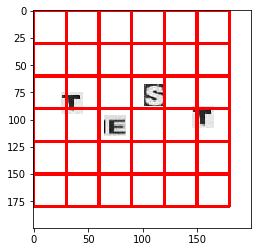

In [1249]:
## Sliding window detection:

import cv2
import matplotlib.pyplot as plt
import numpy as np


def OCR(imagepath):
    # read the image and define the stepSize and window size 
    image = cv2.imread(imagepath) # your image path
    tmp = image # for drawing a rectangle
    stepSize = 30
    (w_width, w_height) = (30,30) # window size
    class_letter = []
    number=[] # To keep track of which square in the grid that is classified
    i = 0 # counter for the number
    windows=[]
    for x in range(0, image.shape[1] - w_width , stepSize):
        for y in range(0, image.shape[0] - w_height, stepSize):
            window = image[x:x + w_width, y:y + w_height, :]
            resize = cv2.resize(window,(20,20),interpolation =cv2.INTER_AREA)
            window = np.asarray(resize)
            window = resize[:, :, 0]
            window=np.reshape(window,20*20)
            window = pd.DataFrame(data=window).T
            windows.append(window)
            list1 = (window.values[0])
            
            # Check if the window is "blank"
            if all(x == list1[0] for x in list1):
                print(" ", end="\r")
                # print("All elements in list are same.")
            else:
                # Classify window:
                prediction  = model_tensor_merged.predict(window.values)
                class_letter.append(prediction)

                # knn
                # class_letter.append(test_classifier_sliding(clf_n,window))
                number.append(i)

            # Plot the grid on top of the image:
            cv2.rectangle(tmp, (x, y), (x + w_width, y + w_height), (255, 0, 0), 2) # draw rectangle on image
            plt.imshow(np.array(tmp).astype('uint8'))
            i+=1
    # show all windows
    plt.show()
    return windows, number, class_letter
    
windows, number, class_letter = OCR("./detection-images/detection-1.jpg")

In [1005]:
def test_classifier_sliding(clf, data):
    y = []
    for row in data.iterrows():
        y.append(clf.predict(([row[1].tolist()])))
    return y

def test_classifier_sliding1(clf, data):
    y = []
    for row in data:
        y.append(clf.predict(([row[1].tolist()])))
    return y

In [1250]:
# Ikke ta med:
prev = 99
count =0
for c in class_letter:
    l = (c[0][0])
    if prev != l:
        print(l,numberDict.get(l),number[count])
        prev = l
        count+=1
        


0.0 A 12


### Printer den klassifiserte dataen fra hele systemet, number er hvilken rute den befinner seg i:

In [1252]:
# Prints the classified data and which square in the grid it belongs to:
print(" ")
i = 0
for c in class_letter:
    num = (np.where(c[0] == (np.amax((c[0]))))[0][0])
    print(numberDict.get(num),number[i])
    i+=1 

 
L 12
L 13
O 15
L 16
L 17
L 18
L 19
E 20
L 22
L 23


### Printing av windows fra sliding window detection:

teller:  0
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


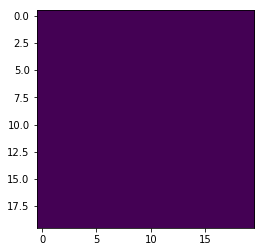

teller:  1
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


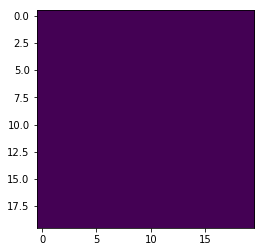

teller:  2
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


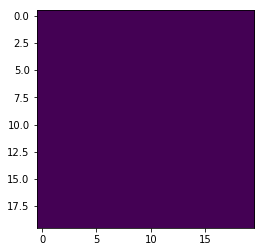

teller:  3
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


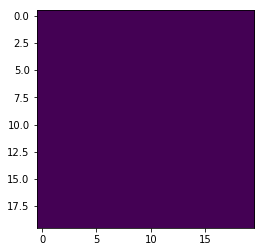

teller:  4
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


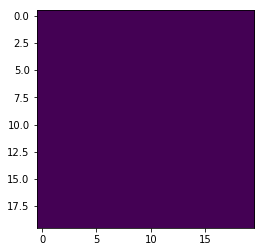

teller:  5
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


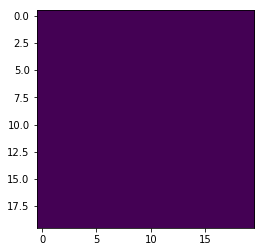

teller:  6
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


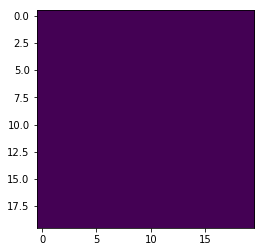

teller:  7
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


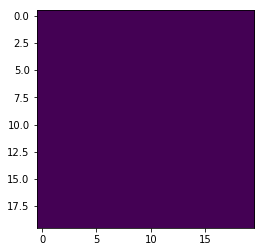

teller:  8
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


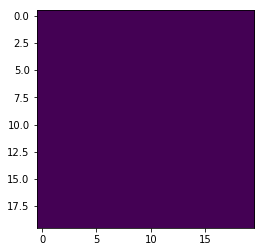

teller:  9
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


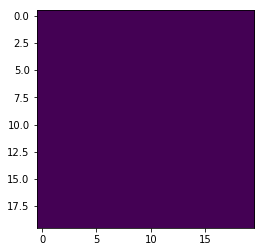

teller:  10
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


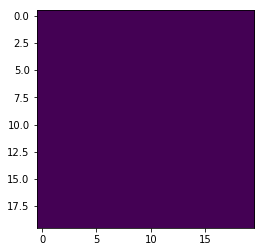

teller:  11
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


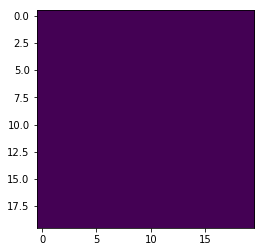

teller:  12
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


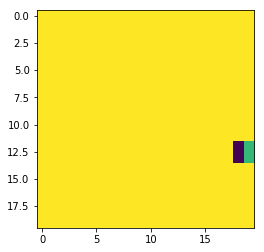

teller:  13
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


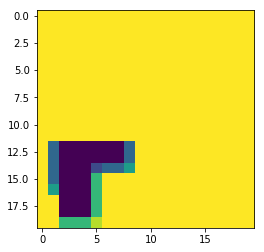

teller:  14
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


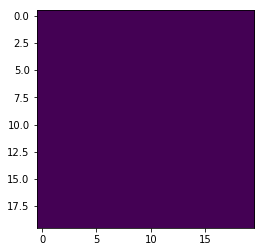

teller:  15
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


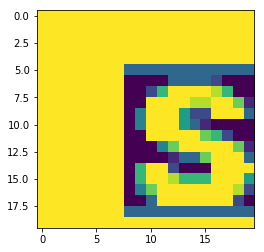

teller:  16
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


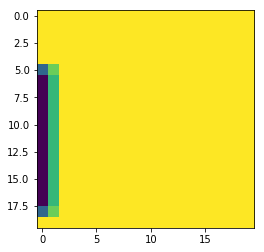

teller:  17
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


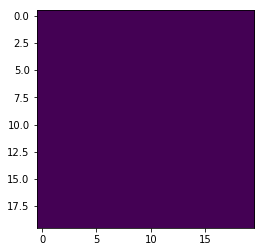

teller:  18
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


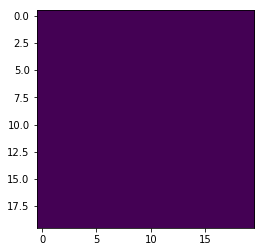

teller:  19
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


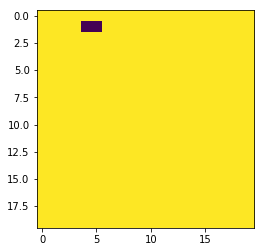

teller:  20
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


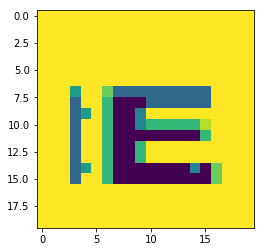

teller:  21
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


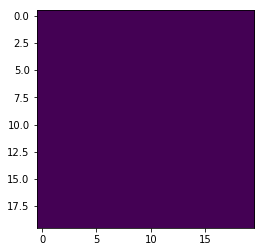

teller:  22
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


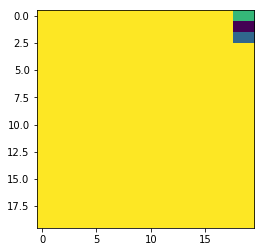

teller:  23
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  170  170  170  170  170  170  170  170  198  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


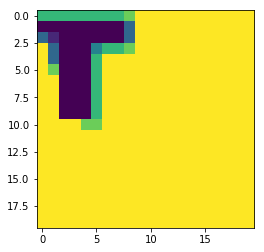

teller:  24
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


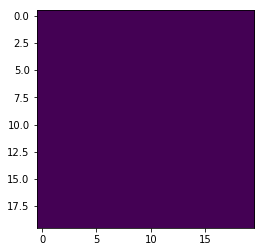

teller:  25
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


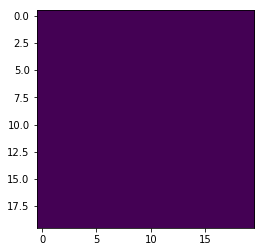

teller:  26
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


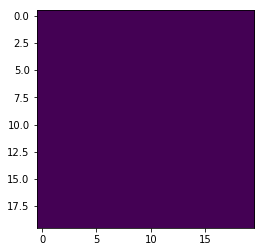

teller:  27
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


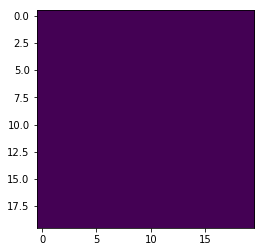

teller:  28
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


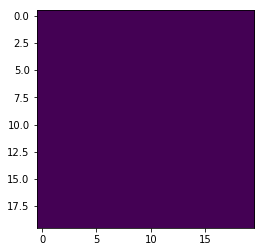

teller:  29
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


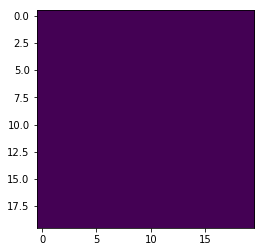

teller:  30
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


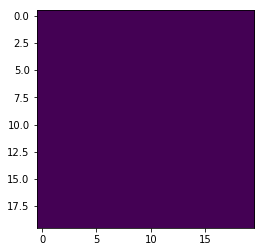

teller:  31
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


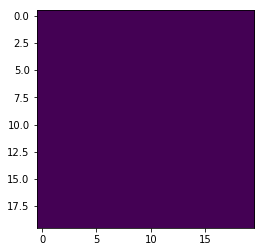

teller:  32
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


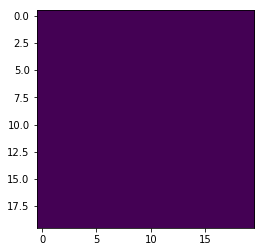

teller:  33
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


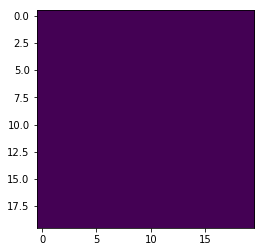

teller:  34
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


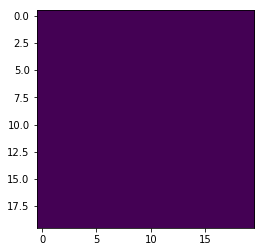

teller:  35
   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
0  255  255  255  255  255  255  255  255  255  255  ...  255  255  255  255   

   394  395  396  397  398  399  
0  255  255  255  255  255  255  

[1 rows x 400 columns]


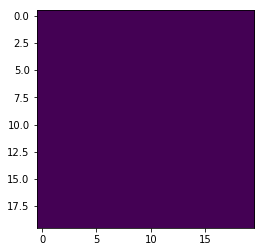

In [1083]:

teller = 0
for win in windows:
    print("teller: ", teller)
    
    print(win)
    w = (win).values.tolist()[0]
    w = np.reshape(w, (20, 20))
    plt.imshow(w)
    plt.show()
    # print(w)
    # print(w)
    teller += 1


True

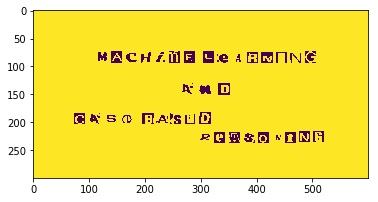

In [1085]:
### IKKE TA MED:


import cv2
img = cv2.imread("./detection-images/detection-2.jpg", 0) 
cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)

contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    # draw a white rectangle to visualize the bounding rect
    cv2.rectangle(img, (x, y), (x + w, y + h), 255, 1)

cv2.drawContours(img, contours, -1, (255, 255, 0), 1)
plt.imshow(img)
cv2.imwrite("output-2.png",img)